# The Battle of Neighborhoods

# Introduction - Discussion of the business problem and the interested audience in this project.

I am a data scientist residing in Milan. 
The key question is: how can I find a convenient and enjoyable place in NY for a future visiting? In order to make a comparison and evaluation of the rental options in Manhattan NY, I must set some basis, therefore the apartment in Manhattan must meet the following demands:
•	apartment must be 2 or 3 bedrooms
•	desired location is near a metro station in the Manhattan area and within 1.0 mile (1.6 km) radius
•	price of rent not exceed $7,000 per month
•	desirable to have venues such as coffee shops, restaurants Asian Thai, wine stores, gym and food shops
•	as a reference, I have included a map of venues near current residence in Singapore.

The challenge is to find a suitable apartment for rent in Manhattan NY that complies with the demands on location, price and venues. The data required to resolve this challenge is described in the data section below.
I believe this is a relevant challenge with valid questions for anyone moving to other large city in US. The same methodology can be applied in accordance to demands as applicable. This case is also applicable for anyone interested in exploring starting or locating a new business in any city. Lastly, it can also serve as a good practical exercise to develop Data Science skills.
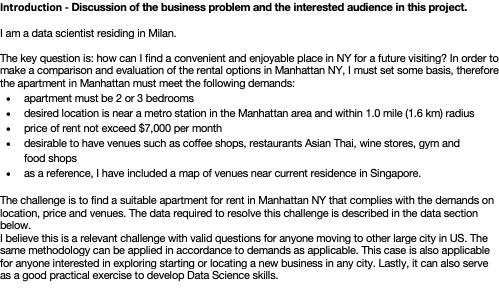

# Data Section - Description of the data and its sources that will be used to solve the problem

The following data is required to answer the issues of the problem:
•	List of Boroughs and neighborhoods of Manhattan with their geodata (latitude and longitude)
•	List of Subway metro stations in Manhattan with their address location
•	List of apartments for rent in Manhattan area with their addresses and price
•	List of apartment for rent with additional information, such as price, address, area, # of beds, etc
•	Venues for each Manhattan neighborhood
•	Venues for subway metro stations, as needed
The data will be used as follows:
•	Use Foursquare and geopy data to map top 10 venues for all Manhattan neighborhoods and clustered in groups
•	Use Foursquare and geopy data to map the location of subway metro stations , separately and on top of the above clustered map in order to be able to identify the venues and amenities near each metro station, or explore each subway location separately
•	Use Foursquare and geopy data to map the location of rental places, in some form, linked to the subway locations.
•	create a map that depicts, for instance, the average rental price per square ft, around a radius of 1.0 mile (1.6 km) around each subway station - or a similar metrics. I will be able to quickly point to the popups to know the relative price per subway area.
•	Addresses from rental locations will be converted to geodata (lat, long) using Geopy-distance and Nominatim.
•	Data will be searched in open data sources if available, from real estate sites if open to reading, libraries or other government agencies such as Metro New York MTA, etc.
The processing of these data will allow to answer the key questions to make a decision:
•	what is the cost of rent (per square ft) around a mile radius from each subway metro station?
•	what is the area of Manhattan with best rental pricing that meets criteria established?
•	What is the distance from work place ( Park Ave and 53 rd St) and the tentative future home?
•	What are the venues of the two best places to live? How the prices compare?
•	How venues distribute among Manhattan neighborhoods and around metro stations?
•	Are there tradeoffs between size and price and location?

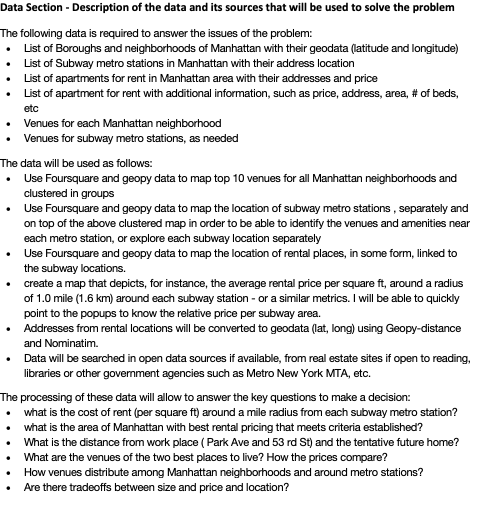

In [7]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Libraries imported.')

Libraries imported.


### MANHATTAN NEIGHBORHOODS - DATA AND MAPPING
Cluster neighborhood data was produced with Foursquare during course lab work.

In [4]:
# Read csv file with clustered neighborhoods with geodata
manhattan_data  = pd.read_csv('mh_neigh_data.csv') 
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,2
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,4
3,Manhattan,Inwood,40.867684,-73.921210,3
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0


### Manhattan Borough neighborhoods - data with top 10 clustered venues

In [5]:
manhattan_merged = pd.read_csv('manhattan_merged.csv')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio


### Map of Manhattan neighborhoods with top 10 clustered venues

In [8]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

# Examine a paticular Cluster - print venues

After examining several cluster data, I concluded that cluster # 2 is the best for my needs.

In [9]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


# Map of Manhattan places for rent¶

Several Manhattan real estate webs were webscrapped to collect rental data. The resut was summarized in a csv file for direct reading, in order to consolidate the proces.

In [10]:
# csv files with rental places with basic data but still wihtout geodata ( latitude and longitude)
# pd.read_csv(' le.csv', header=None, nrows=5)
mh_rent=pd.read_csv('MH_flats_price.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,NaN,NaN
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,NaN,NaN
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,NaN,NaN
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,NaN,NaN
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,NaN,NaN


Obtain geodata ( lat,long) for each rental place in Manhattan with Nominatim. Data was stored in a csv file for simplification.

In [11]:
mh_rent=pd.read_csv('MH_rent_latlong.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


# Map of Manhattan apartments for rent

In [12]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ',  '+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    

map_manhattan_rent

# Map of Manhattan showing the places for rent and the cluster of venues

In [13]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for rental places
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
        # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_clusters2

In the map above, examination of appartments with rental place below 7000/month is straightforwad while knowing the venues around it.

# Mapping Manhattan Subway locations

Manhattan subway metro locations ( address) was obtained from webscrapping sites such as Wikipedia, Google and NY Metro Transit. For simplification, a csv file was produced so that the reading of this file is the starting point here.

In [14]:
# A csv file summarized the subway station and the addresses for next step to determine geodata
mh=pd.read_csv('NYC_subway_list.csv')
mh.head()

,sub_station,sub_address
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA"
1,57 Street Subway Station,"New York, NY 10106, USA"
2,Broad St,"New York, NY 10005, USA"
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA"
4,5 Av and 53 St,"New York, NY 10022, USA"


In [ ]:
#  Add columns 'lat'  and 'long' to mh dataframe - with random temporary numbers to get started
sLength = len(mh['sub_station'])
lat = pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
mh = mh.assign(lat=lat.values)
mh = mh.assign(long=long.values)

In [ ]:
mh.head()

In [19]:
mh=pd.read_csv('MH_subway.csv')
print(mh.shape)
mh.head()

(76, 4)


,sub_station,sub_address,lat,long
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA",40.861857,-73.924509
1,57 Street Subway Station,"New York, NY 10106, USA",40.764250,-73.954525
2,Broad St,"New York, NY 10005, USA",40.730862,-73.987156
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA",40.847991,-73.939785
4,5 Av and 53 St,"New York, NY 10022, USA",40.764250,-73.954525


In [20]:
# removing duplicate rows and creating new set mhsub1
mhsub1=mh.drop_duplicates(subset=['lat','long'], keep="last").reset_index(drop=True)
mhsub1.shape

(22, 4)

# MAP of Manhattan showing the location of subway stations

In [21]:
# map subway stations 
# create map of Manhattan using latitude and longitude values obtain previoulsy via Moninatim geolocator
latitude=40.7308619
longitude=-73.9871558

map_mhsub1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mhsub1) 
map_mhsub1

# Map of Manhattan showing places for rent and the subway locations nearby

In [23]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_manhattan_rent) 
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_manhattan_rent

# Map of Manhattan with rental places, subway locations and cluster of venues

In [25]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_mh_one = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ', '+mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mh_one) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mh_one) 

    # set color scheme for the clusters
kclusters=5
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mh_one)

    # Adds tool to the top right
from folium.plugins import MeasureControl
map_mh_one.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_mh_one)

map_mh_one

# Problem Resolution

The above consolidate map was used to explore options.
After examining, I have chosen two locations that meet the requirements which will assess to make a choice.

Apartment 1: 305 East 63rd Street in the Sutton Place Neighborhood and near 'subway 59th Street' station, Cluster # 2 Monthly rent : 7500 Dollars

Apartment 2: 19 Dutch Street in the Financial District Neighborhood and near 'Fulton Street Subway' station, Cluster # 3 Monthly rent : 6935 Dollars